# Validate Accuracy Scores

In [40]:
import os
import pandas as pd
from sklearn.metrics import root_mean_squared_error, r2_score
from scipy import stats
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [41]:
inputDict = {
    'JASMIN-NL':'/vol/tensusers2/wharmsen/JASMIN-fluency-features/comp-q-read_nl_age7-11_nat',
    'JASMIN-VL':'/vol/tensusers2/wharmsen/JASMIN-fluency-features/comp-q-read_vl_age7-11_nat',
    'SERDA-NL':'/vol/tensusers2/wharmsen/SERDA-fluency-features/comp1'
}

corrDF_list = []
combiDF_list = []
for corpus, basepath in inputDict.items():
    print(corpus)

    manFile = os.path.join(basepath,'06_manual_fluency_features/json-fluency-features/accuracy.tsv')
    manDF = pd.read_csv(manFile, sep = '\t', index_col=0).sort_index()

    asrSystem = 'whispert'
    autoFile = os.path.join(basepath,'05_automatic_fluency_features/' + asrSystem + '/accuracy.tsv')
    autoDF = pd.read_csv(autoFile, sep = '\t', index_col=0).sort_index()
    autoDF.columns = [asrSystem + '_' + x for x in autoDF.columns]

    accVars = list(manDF.columns)
    accVars.remove('other') if 'other' in list(manDF.columns) else list(manDF.columns)
    print('accVars: ', accVars)

    combiDF = pd.concat([autoDF, manDF], axis=1)
    # combiDF = combiDF.dropna()
    print('Length combiDF:', len(combiDF))
    combiDF_list.append(combiDF)

    outputList = []
    for accVar in accVars:
        # Select only the automatic and manual variable
        autoVar = asrSystem + '_' + accVar
        manVar = accVar
        varDF = combiDF.loc[:, [autoVar, manVar]].replace(0, np.nan, inplace=False).dropna()
        length = len(varDF)
        corr = stats.pearsonr(varDF[asrSystem + '_' + accVar], varDF[accVar])[0]
        outputList.append([accVar, length, corr])

    corrDF = pd.DataFrame(outputList, columns = ['var', 'N', corpus]).set_index('var')
    corrDF_list.append(corrDF)

outputCorrDF = pd.concat(corrDF_list, axis=1)

JASMIN-NL
accVars:  ['nr_correct', 'nr_incorrect', 'nr_prompts', 'dur_sec', 'dur_min', 'wcpm', 'perc_cor', 'cor', 'sub', 'del', 'ins', 'sub_perc', 'del_perc', 'ins_perc', 'cor_perc', 'cor_prompt_perc']
Length combiDF: 142
JASMIN-VL
accVars:  ['nr_correct', 'nr_incorrect', 'nr_prompts', 'dur_sec', 'dur_min', 'wcpm', 'perc_cor', 'cor', 'del', 'sub', 'ins', 'sub_perc', 'del_perc', 'ins_perc', 'cor_perc', 'cor_prompt_perc']
Length combiDF: 84
SERDA-NL
accVars:  ['nr_correct', 'nr_incorrect', 'nr_prompts', 'dur_sec', 'dur_min', 'wcpm', 'perc_cor', 'cor', 'sub', 'del', 'ins', 'sub_perc', 'del_perc', 'ins_perc', 'cor_perc', 'cor_prompt_perc']
Length combiDF: 18


In [42]:
outputCorrDF

,N,JASMIN-NL,N,JASMIN-VL,N,SERDA-NL
var,,,,,,
nr_correct,142,0.997140,83,0.999376,18,0.657643
nr_incorrect,140,0.924435,81,0.971016,18,0.677341
nr_prompts,142,1.000000,84,1.000000,18,1.000000
dur_sec,142,0.999931,84,0.999856,18,0.832818
dur_min,142,0.999931,84,0.999856,18,0.832845
wcpm,142,0.989009,83,0.996692,18,0.946681
perc_cor,142,0.868023,83,0.988118,18,0.677448
cor,142,0.996672,83,0.999187,18,0.654513
sub,140,0.780150,82,0.834641,18,0.747683


Observaties:
- JASMIN-NL: Lage correlaties voor ins_perc en sub_perc
- JASMIN-VL: Lage correlaties voor sub_perc
- SERDA-NL: Lage correlaties voor veel variabelen vooral vergeleken met JASMIN. del_perc en ins_perc zijn het laagst.

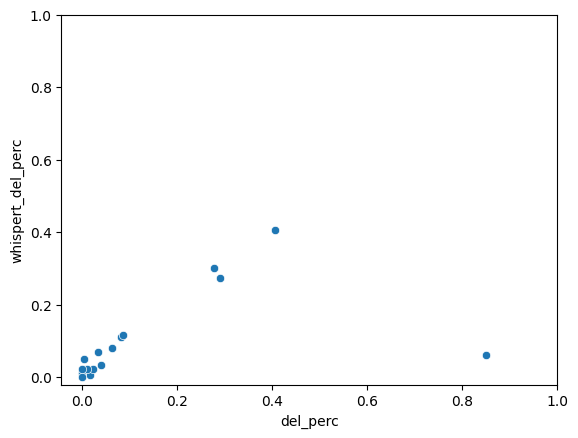

In [52]:
serda_combiDF = combiDF_list[2]
sns.scatterplot(serda_combiDF, x = 'del_perc', y='whispert_del_perc')
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(0,1.2,0.2))
plt.show()

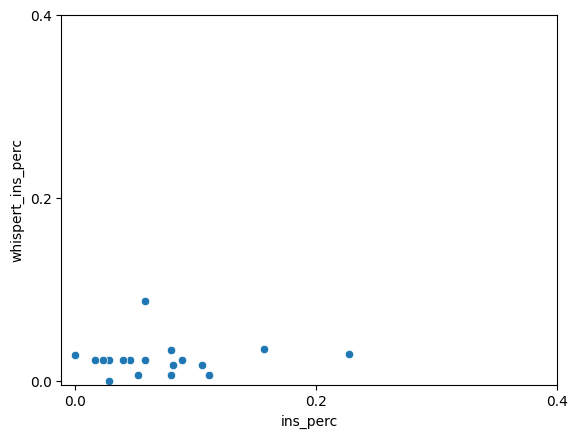

In [54]:
serda_combiDF = combiDF_list[2]
sns.scatterplot(serda_combiDF, x = 'ins_perc', y='whispert_ins_perc')
plt.xticks(np.arange(0,0.6,0.2))
plt.yticks(np.arange(0,0.6,0.2))
plt.show()

Conclusie: whispert herkent deleties vrij goed, op één punt na.

In [55]:
def DF2Latex(outputDF, column_list, txt):
    latex_table = outputDF.to_latex(index=True,
                        columns = column_list,
                        formatters={"name": str.upper},
                        float_format="{:.2f}".format,
                        caption=txt)
    
    # with open(outputFile, 'w') as f:
    #     f.write(latex_table.replace('_', '-'))
    return latex_table.replace('_', '-')

DF2Latex(outputCorrDF, ['auto_var', 'JASMIN-NL', 'JASMIN-VL', 'SERDA-NL'], 'validation')

'\\begin{table}\n\\caption{validation}\n\\begin{tabular}{lrrr}\n\\toprule\n & JASMIN-NL & JASMIN-VL & SERDA-NL \\\\\nvar &  &  &  \\\\\n\\midrule\nnr-correct & 1.00 & 1.00 & 0.66 \\\\\nnr-incorrect & 0.92 & 0.97 & 0.68 \\\\\nnr-prompts & 1.00 & 1.00 & 1.00 \\\\\ndur-sec & 1.00 & 1.00 & 0.83 \\\\\ndur-min & 1.00 & 1.00 & 0.83 \\\\\nwcpm & 0.99 & 1.00 & 0.95 \\\\\nperc-cor & 0.87 & 0.99 & 0.68 \\\\\ncor & 1.00 & 1.00 & 0.65 \\\\\nsub & 0.78 & 0.83 & 0.75 \\\\\ndel & 0.99 & 0.97 & 0.44 \\\\\nins & 0.39 & 0.72 & 0.00 \\\\\nsub-perc & 0.53 & 0.59 & 0.73 \\\\\ndel-perc & 0.98 & 0.79 & 0.45 \\\\\nins-perc & 0.22 & 0.74 & 0.02 \\\\\ncor-perc & 0.85 & 0.99 & 0.67 \\\\\ncor-prompt-perc & 0.87 & 0.99 & 0.68 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'